In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


In [2]:
# BARLOW FORMULAS 

def get_covariance_matrix(rho, sigma_x, sigma_y):
    return np.array([ [sigma_x**2, rho*sigma_x*sigma_y], [rho*sigma_x*sigma_y, sigma_y**2] ])

def get_theta(rho, sigma_x, sigma_y):
    return 0.5 * np.arctan2(2.*rho*sigma_x*sigma_y, (sigma_x**2-sigma_y**2))

def get_sigma_u(sigma_x, sigma_y, theta):
    return np.power(
        (np.cos(theta)**2 * sigma_x**2 - np.sin(theta)**2 * sigma_y**2) / (np.cos(theta)**2 - np.sin(theta)**2), 0.5)

def get_sigma_v(sigma_x, sigma_y, theta):
    return np.power(
        (np.cos(theta)**2 * sigma_y**2 - np.sin(theta)**2 * sigma_x**2) / (np.cos(theta)**2 - np.sin(theta)**2), 0.5)

def get_sigma_x(sigma_u, sigma_v, theta):
    return np.cos(theta)**2 * sigma_u**2 + np.sin(theta)**2 * sigma_v**2

def get_sigma_y(sigma_u, sigma_v, theta):
    return np.cos(theta)**2 * sigma_v**2 + np.sin(theta)**2 * sigma_u**2

def get_rho(theta, sigma_x, sigma_y, sigma_u, sigma_v):
    return np.sin(theta) * np.cos(theta) * (sigma_u**2 - sigma_v**2) / (sigma_x*sigma_y)

In [3]:
# some random numbers
sigma_x = 2.
sigma_y = 3.
rho = 0.5

M = get_covariance_matrix(rho, sigma_x, sigma_y)

# BARLOW
theta = get_theta(rho, sigma_x, sigma_y)
sigma_u = get_sigma_u(sigma_x, sigma_y, theta)
sigma_v = get_sigma_v(sigma_x, sigma_y, theta)
got_rho = get_rho(theta, sigma_x, sigma_y, sigma_u, sigma_v)
# print(" got_Rho = {}\n theta = {}\n sigma_u = {}\n sigma_v={}".format(rho, np.rad2deg(theta), sigma_u, sigma_v))

# ANTHONY / ME (in the gnss-converters repo)
trace = np.trace(M)
det = np.linalg.det(M)
eigen_value_1 = (trace/2. + np.sqrt(((trace*trace)/4.)-det))
eigen_value_2 = (trace/2. - np.sqrt(((trace*trace)/4.)-det))
semi_major = np.sqrt(eigen_value_1)
semi_minor = np.sqrt(eigen_value_2)
orientation = np.arctan(M[1,0]/(eigen_value_1 - M[1,1]))

## Now compare BARLOW vs Anthony / me

In [4]:
print(M)
print(" semi-major, sigma_u = {}, {}\n semi-minor, sigma_v = {}, {}".format(semi_major, sigma_u, semi_minor, sigma_v))
print("orientation, theta = {}, {}".format(np.degrees(orientation), np.degrees(theta)))

[[4. 3.]
 [3. 9.]]
 semi-major, sigma_u = 3.2256975738517903, 3.2256975738517903
 semi-minor, sigma_v = 1.610861621011151, 1.610861621011151
orientation, theta = 64.9027855461326, 64.9027855461326


### Yay! it's the same. Though Barlow won't like theta=45º since it gets a divide-by-zero pb

## now compare anthony/me vs plot technic below

In [5]:

# covariance matrix of plot data (fixed seed of 3 with 200 data points)
cov_plot = np.array([[4.75247453, 3.02906372], [3.02906372, 8.47866764]])

#  plot method (same as ours but we still wanna double-check, the minor diff is their eigen vecs are normalized)
vals_plot, vecs_plot = np.linalg.eigh(cov_plot)
order_plot = vals_plot.argsort()[::-1]
vecs_plot = vecs_plot[:, order_plot]
trace_plot = np.trace(cov_plot)
det_plot = np.linalg.det(cov_plot)

# anthony/me method, largest eigen value:
L1_plot = (trace_plot/2. + np.sqrt(((trace_plot*trace_plot)/4.)-det_plot))

L1_vec = np.array([L1_plot-cov_plot[1,1], cov_plot[1,0]])
print("L1_vec anthony/me, warning: not normwlized", L1_vec)
print("L1_vec anthony/me, normwlized", L1_vec/np.linalg.norm(L1_vec))
print("L1_vec plot: ", vecs_plot[:,0])


print("\n")
print("anthony: ", np.degrees( np.arctan( cov_plot[1,0] / (L1_plot - cov_plot[1,1]) ) ) ) 
print("atan2 *vecs: ", np.degrees(np.arctan2(*vecs_plot[:,0][::-1])))
print("\n")



L1_vec anthony/me, warning: not normwlized [1.69307495 3.02906372]
L1_vec anthony/me, normwlized [0.48790104 0.87289895]
L1_vec plot:  [0.48790104 0.87289895]


anthony:  60.7972837313076
atan2 *vecs:  60.79728373130757




## Yay, it's the same also! 

cov:
 [[4.75247453 3.02906372]
 [3.02906372 8.47866764]] 

eigen_vals =  [10.17174259  3.05939957]
width =  12.757267791831072
height =  6.996455755712796
theta =  60.79728371547114


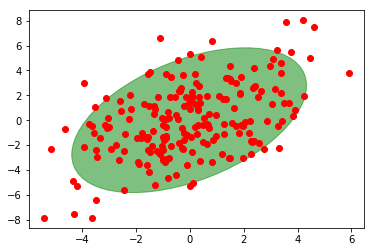

IF YOU USE CONFIDENCE_FACTOR (see Torrieri paper), you'll get proper cover. WARNING: for 2D gaussian case, 1-sigma DOES NOT cover 68%, it's more like 60%, that's what you see if you use PROBSA_COVER=0/6
When using just nstd, no confidence, you re in fact plotting an ERROR ELLIPSE (noaa paper on ellipsoids cf. bookmark), NOT a CONFIDENCE ELLIPSE (torrieri)


In [6]:
np.random.seed(3)
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    print("cov:\n", cov, "\n")
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    PROBA_COVER = 0.5 # this is the "1-sigma" equivalent in 2D gaussian world. See https://math.stackexchange.com/questions/143377/3-sigma-rule-for-multivariate-normal-distribution

    CONFIDENCE_FACTOR = -2. * np.log(1. - PROBA_COVER)
    # use regular stuff for now
    # 
    CONFIDENCE_FACTOR = 1.0

    width, height = 2 * nstd * np.sqrt(vals * CONFIDENCE_FACTOR)
    print ("eigen_vals = ", vals)
    print ("width = ", width)
    print ("height = ", height)
    print ("theta = ", theta)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

#-- Example usage -----------------------
# Generate some random, correlated data
points = np.random.multivariate_normal(
        mean=(0,0), cov=[[2.**2, 0.5*2*3],[0.5*2*3, 3**2]], size=200
        )
# Plot the raw points...
x, y = points.T
plt.plot(x, y, 'ro')

# Plot a transparent 3 standard deviation covariance ellipse
plot_point_cov(points, nstd=2, alpha=0.5, color='green')

plt.show()
print("IF YOU USE CONFIDENCE_FACTOR (see Torrieri paper), you'll get proper cover. WARNING: for 2D gaussian case, 1-sigma DOES NOT cover 68%, it's more like 60%, that's what you see if you use PROBSA_COVER=0/6")
print("When using just nstd, no confidence, you re in fact plotting an ERROR ELLIPSE (noaa paper on ellipsoids cf. bookmark), NOT a CONFIDENCE ELLIPSE (torrieri)")